In [1]:
!pip install pyspark
!export SPARK_HOME=/opt/spark
!export PATH=$SPARK_HOME/bin:$PATH
!export PYSPARK_DRIVER_PYTHON=jupyter
!export PYSPARK_DRIVER_PYTHON_OPTS='notebook'
!pip install findspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import socket
import json
from collections import namedtuple
%matplotlib inline 

In [2]:
import threading
import time
import  socket
def create_socket():
    s = socket.socket()         
    host = "127.0.0.1"     
    port = 5555                 
    s.bind((host, port))       
    listen = TweetsListener(s)
    print("Listening on port: %s " % str(port))
    s.listen(5)               
    c, addr = s.accept()        
    print( "Received request from: " + str( addr ) )
    listen.sendData( c )

In [3]:
class TweetsListener(StreamListener):
    def __init__(self, csocket):
        self.client_socket = csocket
    def on_data(self, data):
        try:
            msg = json.loads( data )
            self.client_socket.send( msg['text'].encode('utf-8') )
            return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

    def on_error(self, status):
        print(status)
        return True

    def sendData(self, c_socket):
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_secret)

        twitter_stream = Stream(auth, TweetsListener(c_socket))
        twitter_stream.filter(track=['army'])

In [4]:
consumer_key='Z80DRI89sPY7In3wH1tBl8jHo'
consumer_secret='XJyPCkWeKfwC4gwfN6dhK52hJiW1NXJpuEhWtSv2dpivPA2sou'
access_token ='1043483407005691904-i0pT7mKBhqGsVSA3bKKCbkth6twi4F'
access_secret='fBnYRYZKNgb29wgzthQ25aeGATyTBNXtVNbnsEzsUDavy'

In [5]:
sc = SparkContext()
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)
lines = socket_stream.window( 20 )
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )
( lines.flatMap( lambda text: text.split( " " ) ) 
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) 
  .reduceByKey( lambda a, b: a + b ) 
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) 
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) 
  .limit(10).registerTempTable("tweets") ) ) 

In [6]:
def plot_graph():
    while True:
        print("The data is refreshed every 30 seconds so next graph will be plotted after 30 seconds have elapsed.")
        top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
        top_10_df = top_10_tweets.toPandas()
        display.clear_output(wait=True)
        plt.figure( figsize = ( 16, 12 ) )
        plt.tight_layout()
        sns.barplot( x="count", y="tag", palette="rocket", data=top_10_df)
        plt.show()
        time.sleep(30)
    ssc.stop()

In [7]:
def start():
    t1=threading.Thread(target=create_socket)
    t1.daemon = True
    t1.start()
    ssc.start()
    print("Thread for socket started successfully. Starting streaming now")
    print("Fetching data from Twitter. First graph will be plotted after 30 seconds!")
    time.sleep(30)
    t2=threading.Thread(target=plot_graph)
    t2.start()

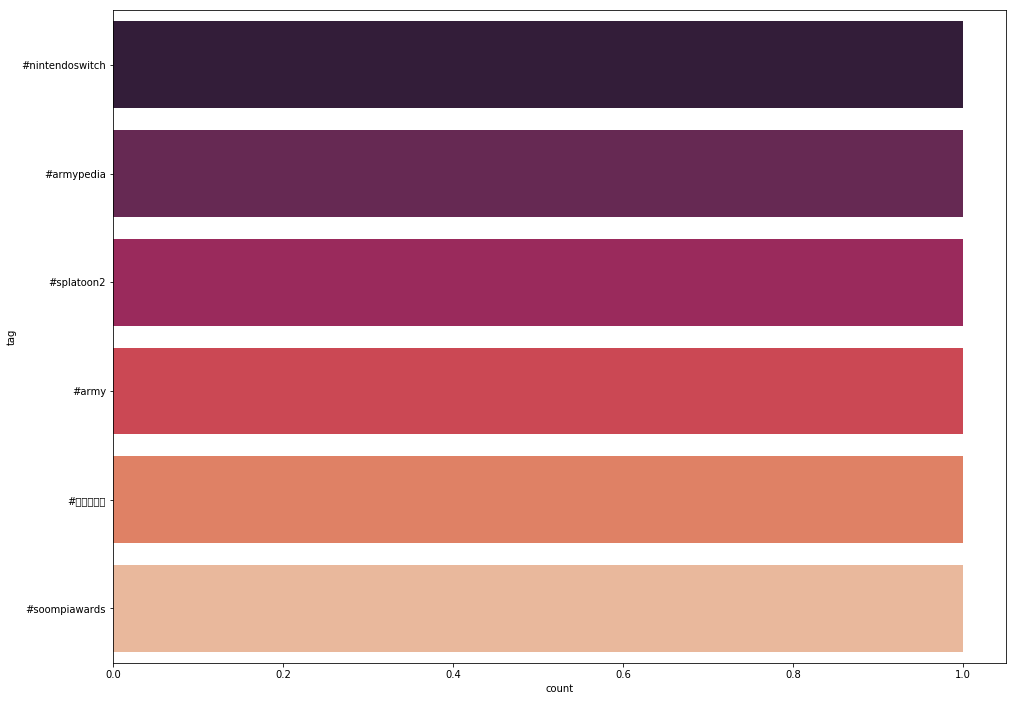

In [8]:
start()